# Previsão de Doenças Cardiovasculares

O objetivo é prever a feature **Heart Disease Status**.

## Dataset & Análise

O dataset elegido para este estudo foi **"Heart Disease Dataset (Comprehensive)**

Este dataset combina os dados de 5 pesquisas de Cleveland, Hungarian, Switzerland, Long Beach VA, and Statlog, com um total de 1,190 pessoas sendo 76% utentes masculinos com cerca de 11 features em comum

O Autor do dataset é `Manu Siddhartha  (Liverpool John Moore's University)`

### Necessário 

> **Dataset**  - `heart_statlog_cleveland_hungary_final.csv`
>
> **Obtido em** - `https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive`


**Questões adicionais**

-Quais variáveis mais influenciam o risco? (feature importance)

-Modelos mais simples funcionam tão bem quanto modelos complexos?

-Podemos otimizar o recall sem perder muita precisão?

-Existe algum grupo com maior risco (ex.: idade, sexo)?
        

In [1]:
!pip install -q mlxtend
!pip install -q catboost
!pip install -q xgboost
!pip install -q lightgbm

In [32]:
# Manipulação de dados
import pandas as pd
import numpy as np
from collections import Counter

# Pré-processamento
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Seleção de features
from sklearn.feature_selection import SelectFromModel

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

import xgboost as xgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Validação e métricas
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, silhouette_score)

# Clusterização e redução de dimensionalidade
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# Regras de associação
from mlxtend.frequent_patterns import apriori, association_rules

# Visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Utilitários
import joblib
from scipy import stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Bibliotecas importadas com sucesso")
warnings.filterwarnings('ignore')

# Configuração padrão de plots
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 120

✓ Bibliotecas importadas com sucesso


In [3]:
dataset_path = "./heart_statlog_cleveland_hungary_final.csv"
df = pd.read_csv(dataset_path)

# Formatação Data Set
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('...', '')

display(df.head())

# Debugg Extra
print(df.columns)
print(df.shape)
print(df.info()) 

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


Index(['age', 'sex', 'chest_pain_type', 'resting_bp_s', 'cholesterol',
       'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate',
       'exercise_angina', 'oldpeak', 'st_slope', 'target'],
      dtype='object')
(1190, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest_pain_type      1190 non-null   int64  
 3   resting_bp_s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting_blood_sugar  1190 non-null   int64  
 6   resting_ecg          1190 non-null   int64  
 7   max_heart_rate       1190 non-null   int64  
 8   exercise_angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  st_slope             1190 non-null   int64  
 11  target     

***

## EDA - Análise Exploratória de Dados

De forma a entender a estrutura, qualidade e as relações subjacentes do dataset, e tendo em conta que o DataFrame é tanto numérico padronizado e categórico, a análise exploratória deve ser focada em duas áreas principais, a Visão Geral e Análise Bivariada.

As `colunas de exceção` contêm None como um possivel valor, porém este valor tem significado e deve ser mantido e não retirado como NaN. Porém é necessário tratar estes valor para que estes valores não sejam retirados do dataset, pois representam ~30% do dataset  

In [4]:
target_col = "target"

categorical_cols = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg",
    "exercise_angina",
    "st_slope"
]

numeric_cols = [
    "age",
    "resting_bp_s",
    "cholesterol",
    "max_heart_rate",
    "oldpeak"
]

### Limpeza dos dados

In [5]:
print("\n" + "="*80)
print("LIMPEZA E PREPARAÇÃO DOS DADOS")
print("="*80)

# Verificar valores ausentes iniciais
print("\nValores ausentes por coluna:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ Nenhum valor ausente detectado")

# Converter numéricas
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Converter categóricas
for col in categorical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Verificar target
print(f"\nDistribuição da variável target:")
print(df[target_col].value_counts())
print(f"\nProporção:")
print(df[target_col].value_counts(normalize=True).round(3))

# Remover linhas com NaN nas numéricas
linhas_antes = len(df)
df = df.dropna(subset=numeric_cols)
linhas_depois = len(df)

print(f"\n✓ Linhas removidas: {linhas_antes - linhas_depois}")
print(f"✓ Dataset final: {linhas_depois} linhas")

# Preparar target
y = df[target_col].astype(int)
print(f"\n✓ Distribuição final: {Counter(y)}")

if len(Counter(y)) > 1:
    counts = Counter(y)
    ratio = max(counts.values()) / min(counts.values())
    print(f"✓ Ratio desbalanceamento: {ratio:.2f}:1")
    
    if ratio > 3:
        print("  ⚠️ Dataset desbalanceado - considerar técnicas de balanceamento")
    elif ratio > 1.5:
        print("  ℹ️ Leve desbalanceamento - monitorar métricas além da acurácia")
    else:
        print("  ✓ Dataset balanceado")



LIMPEZA E PREPARAÇÃO DOS DADOS

Valores ausentes por coluna:
✓ Nenhum valor ausente detectado

Distribuição da variável target:
target
1    629
0    561
Name: count, dtype: int64

Proporção:
target
1    0.529
0    0.471
Name: proportion, dtype: float64

✓ Linhas removidas: 0
✓ Dataset final: 1190 linhas

✓ Distribuição final: Counter({1: 629, 0: 561})
✓ Ratio desbalanceamento: 1.12:1
  ✓ Dataset balanceado


### Estatísticas Descritivas

In [7]:
print("\n" + "="*80)
print("ESTATÍSTICAS DESCRITIVAS")
print("="*80)

# Numéricas
print("\nVariáveis Numéricas:")
print(df[numeric_cols].describe().round(2))

# Verificar outliers potenciais (IQR method)
print("\nDetecção de Outliers (método IQR):")
outlier_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(df)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'N_Outliers': outliers,
        'Percentual': f"{outlier_pct:.1f}%",
        'Limite_Inferior': f"{lower_bound:.2f}",
        'Limite_Superior': f"{upper_bound:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

# Categóricas
print("\n\nVariáveis Categóricas:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().sort_index())



ESTATÍSTICAS DESCRITIVAS

Variáveis Numéricas:
           age  resting_bp_s  cholesterol  max_heart_rate  oldpeak
count  1190.00       1190.00      1190.00         1190.00  1190.00
mean     53.72        132.15       210.36          139.73     0.92
std       9.36         18.37       101.42           25.52     1.09
min      28.00          0.00         0.00           60.00    -2.60
25%      47.00        120.00       188.00          121.00     0.00
50%      54.00        130.00       229.00          140.50     0.60
75%      60.00        140.00       269.75          160.00     1.60
max      77.00        200.00       603.00          202.00     6.20

Detecção de Outliers (método IQR):
       Feature  N_Outliers Percentual Limite_Inferior Limite_Superior
           age           0       0.0%           27.50           79.50
  resting_bp_s          37       3.1%           90.00          170.00
   cholesterol         193      16.2%           65.38          392.38
max_heart_rate           1       

### ANÁLISE DE SEPARABILIDADE

In [14]:
print("\n" + "="*80)
print("ANÁLISE DE SEPARABILIDADE DAS FEATURES")
print("="*80)

separability = []
for col in numeric_cols:
    class_0 = df[df[target_col] == 0][col].dropna()
    class_1 = df[df[target_col] == 1][col].dropna()
    
    # Mann-Whitney U test
    stat, p_value = mannwhitneyu(class_0, class_1, alternative='two-sided')
    
    # Cohen's d
    mean_diff = class_1.mean() - class_0.mean()
    pooled_std = np.sqrt((class_0.std()**2 + class_1.std()**2) / 2)
    cohens_d = abs(mean_diff / pooled_std) if pooled_std > 0 else 0
    
    # Classificação do efeito
    if cohens_d < 0.2:
        effect = "Desprezível"
    elif cohens_d < 0.5:
        effect = "Pequeno"
    elif cohens_d < 0.8:
        effect = "Médio"
    else:
        effect = "Grande"
    
    separability.append({
        'Feature': col,
        "Cohen's d": round(cohens_d, 3),
        'Efeito': effect,
        'p-value': f"{p_value:.4f}",
        'Média Classe 0': round(class_0.mean(), 2),
        'Média Classe 1': round(class_1.mean(), 2),
        'Diferença %': round(abs(mean_diff / class_0.mean() * 100) if class_0.mean() != 0 else 0, 1)
    })

sep_df = pd.DataFrame(separability).sort_values("Cohen's d", ascending=False)
print("\nRanking de Features por Poder Discriminativo:")
print(sep_df.to_string(index=False))

# Resumo estatístico
negligible = (sep_df["Cohen's d"].astype(float) < 0.2).sum()
small = ((sep_df["Cohen's d"].astype(float) >= 0.2) & (sep_df["Cohen's d"].astype(float) < 0.5)).sum()
medium = ((sep_df["Cohen's d"].astype(float) >= 0.5) & (sep_df["Cohen's d"].astype(float) < 0.8)).sum()
large = (sep_df["Cohen's d"].astype(float) >= 0.8).sum()

print(f"\n{'='*50}")
print("RESUMO DO PODER DISCRIMINATIVO:")
print(f"{'='*50}")
print(f"✗ Efeito Desprezível (< 0.2): {negligible} features")
print(f"~ Efeito Pequeno (0.2-0.5):   {small} features")
print(f"+ Efeito Médio (0.5-0.8):     {medium} features")
print(f"✓ Efeito Grande (≥ 0.8):      {large} features")

if large >= 2:
    print("\n✓ Bom potencial preditivo - múltiplas features discriminativas")
elif large + medium >= 3:
    print("\n~ Potencial moderado - algumas features úteis")
else:
    print("\n⚠️ Alerta - poucas features com bom poder discriminativo")




ANÁLISE DE SEPARABILIDADE DAS FEATURES

Ranking de Features por Poder Discriminativo:
       Feature  Cohen's d  Efeito p-value  Média Classe 0  Média Classe 1  Diferença %
max_heart_rate      0.910  Grande  0.0000          150.89          129.78         14.0
       oldpeak      0.880  Grande  0.0000            0.46            1.33        186.5
           age      0.542   Médio  0.0000           51.12           56.03          9.6
   cholesterol      0.411 Pequeno  0.0028          231.66          191.37         17.4
  resting_bp_s      0.246 Pequeno  0.0000          129.79          134.26          3.4

RESUMO DO PODER DISCRIMINATIVO:
✗ Efeito Desprezível (< 0.2): 0 features
~ Efeito Pequeno (0.2-0.5):   2 features
+ Efeito Médio (0.5-0.8):     1 features
✓ Efeito Grande (≥ 0.8):      2 features

✓ Bom potencial preditivo - múltiplas features discriminativas


### SOBREPOSIÇÃO DAS DISTRIBUIÇÕES

In [16]:
print("\n" + "="*80)
print("QUANTIFICAÇÃO DA SOBREPOSIÇÃO DAS DISTRIBUIÇÕES")
print("="*80)

overlaps = []
for col in numeric_cols:
    class_0 = df[df[target_col] == 0][col].dropna()
    class_1 = df[df[target_col] == 1][col].dropna()
    
    min_0, max_0 = class_0.min(), class_0.max()
    min_1, max_1 = class_1.min(), class_1.max()
    
    # Overlap range
    overlap_min = max(min_0, min_1)
    overlap_max = min(max_0, max_1)
    
    if overlap_max > overlap_min:
        overlap_range = overlap_max - overlap_min
        total_range = max(max_0, max_1) - min(min_0, min_1)
        overlap_pct = (overlap_range / total_range * 100) if total_range > 0 else 0
    else:
        overlap_pct = 0
    
    overlaps.append({
        'Feature': col,
        'Sobreposição %': round(overlap_pct, 1),
        'Range Classe 0': f"[{min_0:.1f}, {max_0:.1f}]",
        'Range Classe 1': f"[{min_1:.1f}, {max_1:.1f}]"
    })

overlap_df = pd.DataFrame(overlaps).sort_values('Sobreposição %', ascending=False)
print("\nSobreposição dos Ranges por Feature:")
print(overlap_df.to_string(index=False))

avg_overlap = overlap_df['Sobreposição %'].mean()
print(f"\n{'='*50}")
print(f"Sobreposição média: {avg_overlap:.1f}%")
print(f"{'='*50}")

if avg_overlap > 90:
    print("⚠️ PROBLEMA CRÍTICO: Sobreposição > 90%")
    print("   → As distribuições são praticamente idênticas!")
    print("   → Modelo terá muita dificuldade em separar as classes")
elif avg_overlap > 80:
    print("⚠️ PROBLEMA SÉRIO: Sobreposição > 80%")
    print("   → Difícil separar as classes")
    print("   → Considerar feature engineering ou modelos não-lineares")
elif avg_overlap > 60:
    print("~ DESAFIO MODERADO: Sobreposição entre 60-80%")
    print("   → Separação possível mas não trivial")
else:
    print("✓ Sobreposição aceitável (< 60%)")
    print("   → Boas perspectivas de classificação")



QUANTIFICAÇÃO DA SOBREPOSIÇÃO DAS DISTRIBUIÇÕES

Sobreposição dos Ranges por Feature:
       Feature  Sobreposição % Range Classe 0 Range Classe 1
   cholesterol            93.5   [0.0, 564.0]   [0.0, 603.0]
           age            91.8   [28.0, 76.0]   [31.0, 77.0]
max_heart_rate            88.7  [69.0, 202.0]  [60.0, 195.0]
       oldpeak            60.2    [-1.1, 4.2]    [-2.6, 6.2]
  resting_bp_s            55.0  [80.0, 190.0]   [0.0, 200.0]

Sobreposição média: 77.8%
~ DESAFIO MODERADO: Sobreposição entre 60-80%
   → Separação possível mas não trivial


### Análise das correlações

In [19]:
print("\n" + "="*80)
print("ANÁLISE DE CORRELAÇÕES")
print("="*80)

# Correlação entre features numéricas
corr_matrix = df[numeric_cols + [target_col]].corr()

print("\nCorrelações com o Target:")
target_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
print(target_corr)

# Identificar correlações fortes entre features (multicolinearidade)
print("\n\nMulticolinearidade (|corr| > 0.7):")
high_corr = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_val = corr_matrix.loc[numeric_cols[i], numeric_cols[j]]
        if abs(corr_val) > 0.7:
            high_corr.append({
                'Feature 1': numeric_cols[i],
                'Feature 2': numeric_cols[j],
                'Correlação': round(corr_val, 3)
            })

if high_corr:
    print(pd.DataFrame(high_corr).to_string(index=False))
    print("\n⚠️ Atenção: Features altamente correlacionadas podem causar problemas")
else:
    print("✓ Nenhuma correlação forte detectada (< 0.7)")




ANÁLISE DE CORRELAÇÕES

Correlações com o Target:
oldpeak           0.398385
age               0.262029
resting_bp_s      0.121415
cholesterol      -0.198366
max_heart_rate   -0.413278
Name: target, dtype: float64


Multicolinearidade (|corr| > 0.7):
✓ Nenhuma correlação forte detectada (< 0.7)


### ANÁLISE DE ASSOCIAÇÃO - VARIÁVEIS CATEGÓRICAS vs TARGET

In [34]:
print("\n" + "="*80)
print("ANÁLISE DE ASSOCIAÇÃO - VARIÁVEIS CATEGÓRICAS vs TARGET")
print("="*80)

categorical_associations = []
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[target_col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Cramér's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
    
    categorical_associations.append({
        'Feature': col,
        "Cramér's V": round(cramers_v, 3),
        'Chi² p-value': f"{p_value:.4f}",
        'Associação': 'Forte' if cramers_v > 0.3 else 'Moderada' if cramers_v > 0.1 else 'Fraca'
    })

cat_assoc_df = pd.DataFrame(categorical_associations).sort_values("Cramér's V", ascending=False)
print("\nForça de Associação com Target:")
print(cat_assoc_df.to_string(index=False))

# Mostrar distribuições por classe
print("\n\nDistribuições Condicionais (% por classe):")
for col in categorical_cols:
    print(f"\n{col}:")
    cross_tab = pd.crosstab(df[col], df[target_col], normalize='columns') * 100
    print(cross_tab.round(1))



ANÁLISE DE ASSOCIAÇÃO - VARIÁVEIS CATEGÓRICAS vs TARGET

Força de Associação com Target:
            Feature  Cramér's V Chi² p-value Associação
           st_slope       0.570       0.0000      Forte
    chest_pain_type       0.530       0.0000      Forte
    exercise_angina       0.480       0.0000      Forte
                sex       0.309       0.0000      Forte
fasting_blood_sugar       0.215       0.0000   Moderada
        resting_ecg       0.124       0.0001   Moderada


Distribuições Condicionais (% por classe):

sex:
target     0     1
sex               
0       37.6  11.1
1       62.4  88.9

chest_pain_type:
target              0     1
chest_pain_type            
1                 7.3   4.0
2                33.0   4.9
3                34.4  14.3
4                25.3  76.8

fasting_blood_sugar:
target                  0     1
fasting_blood_sugar            
0                    88.1  70.3
1                    11.9  29.7

resting_ecg:
target          0     1
resting_ecg      


GERANDO VISUALIZAÇÕES...
✓ Gráfico salvo: distribuicoes_numericas.png


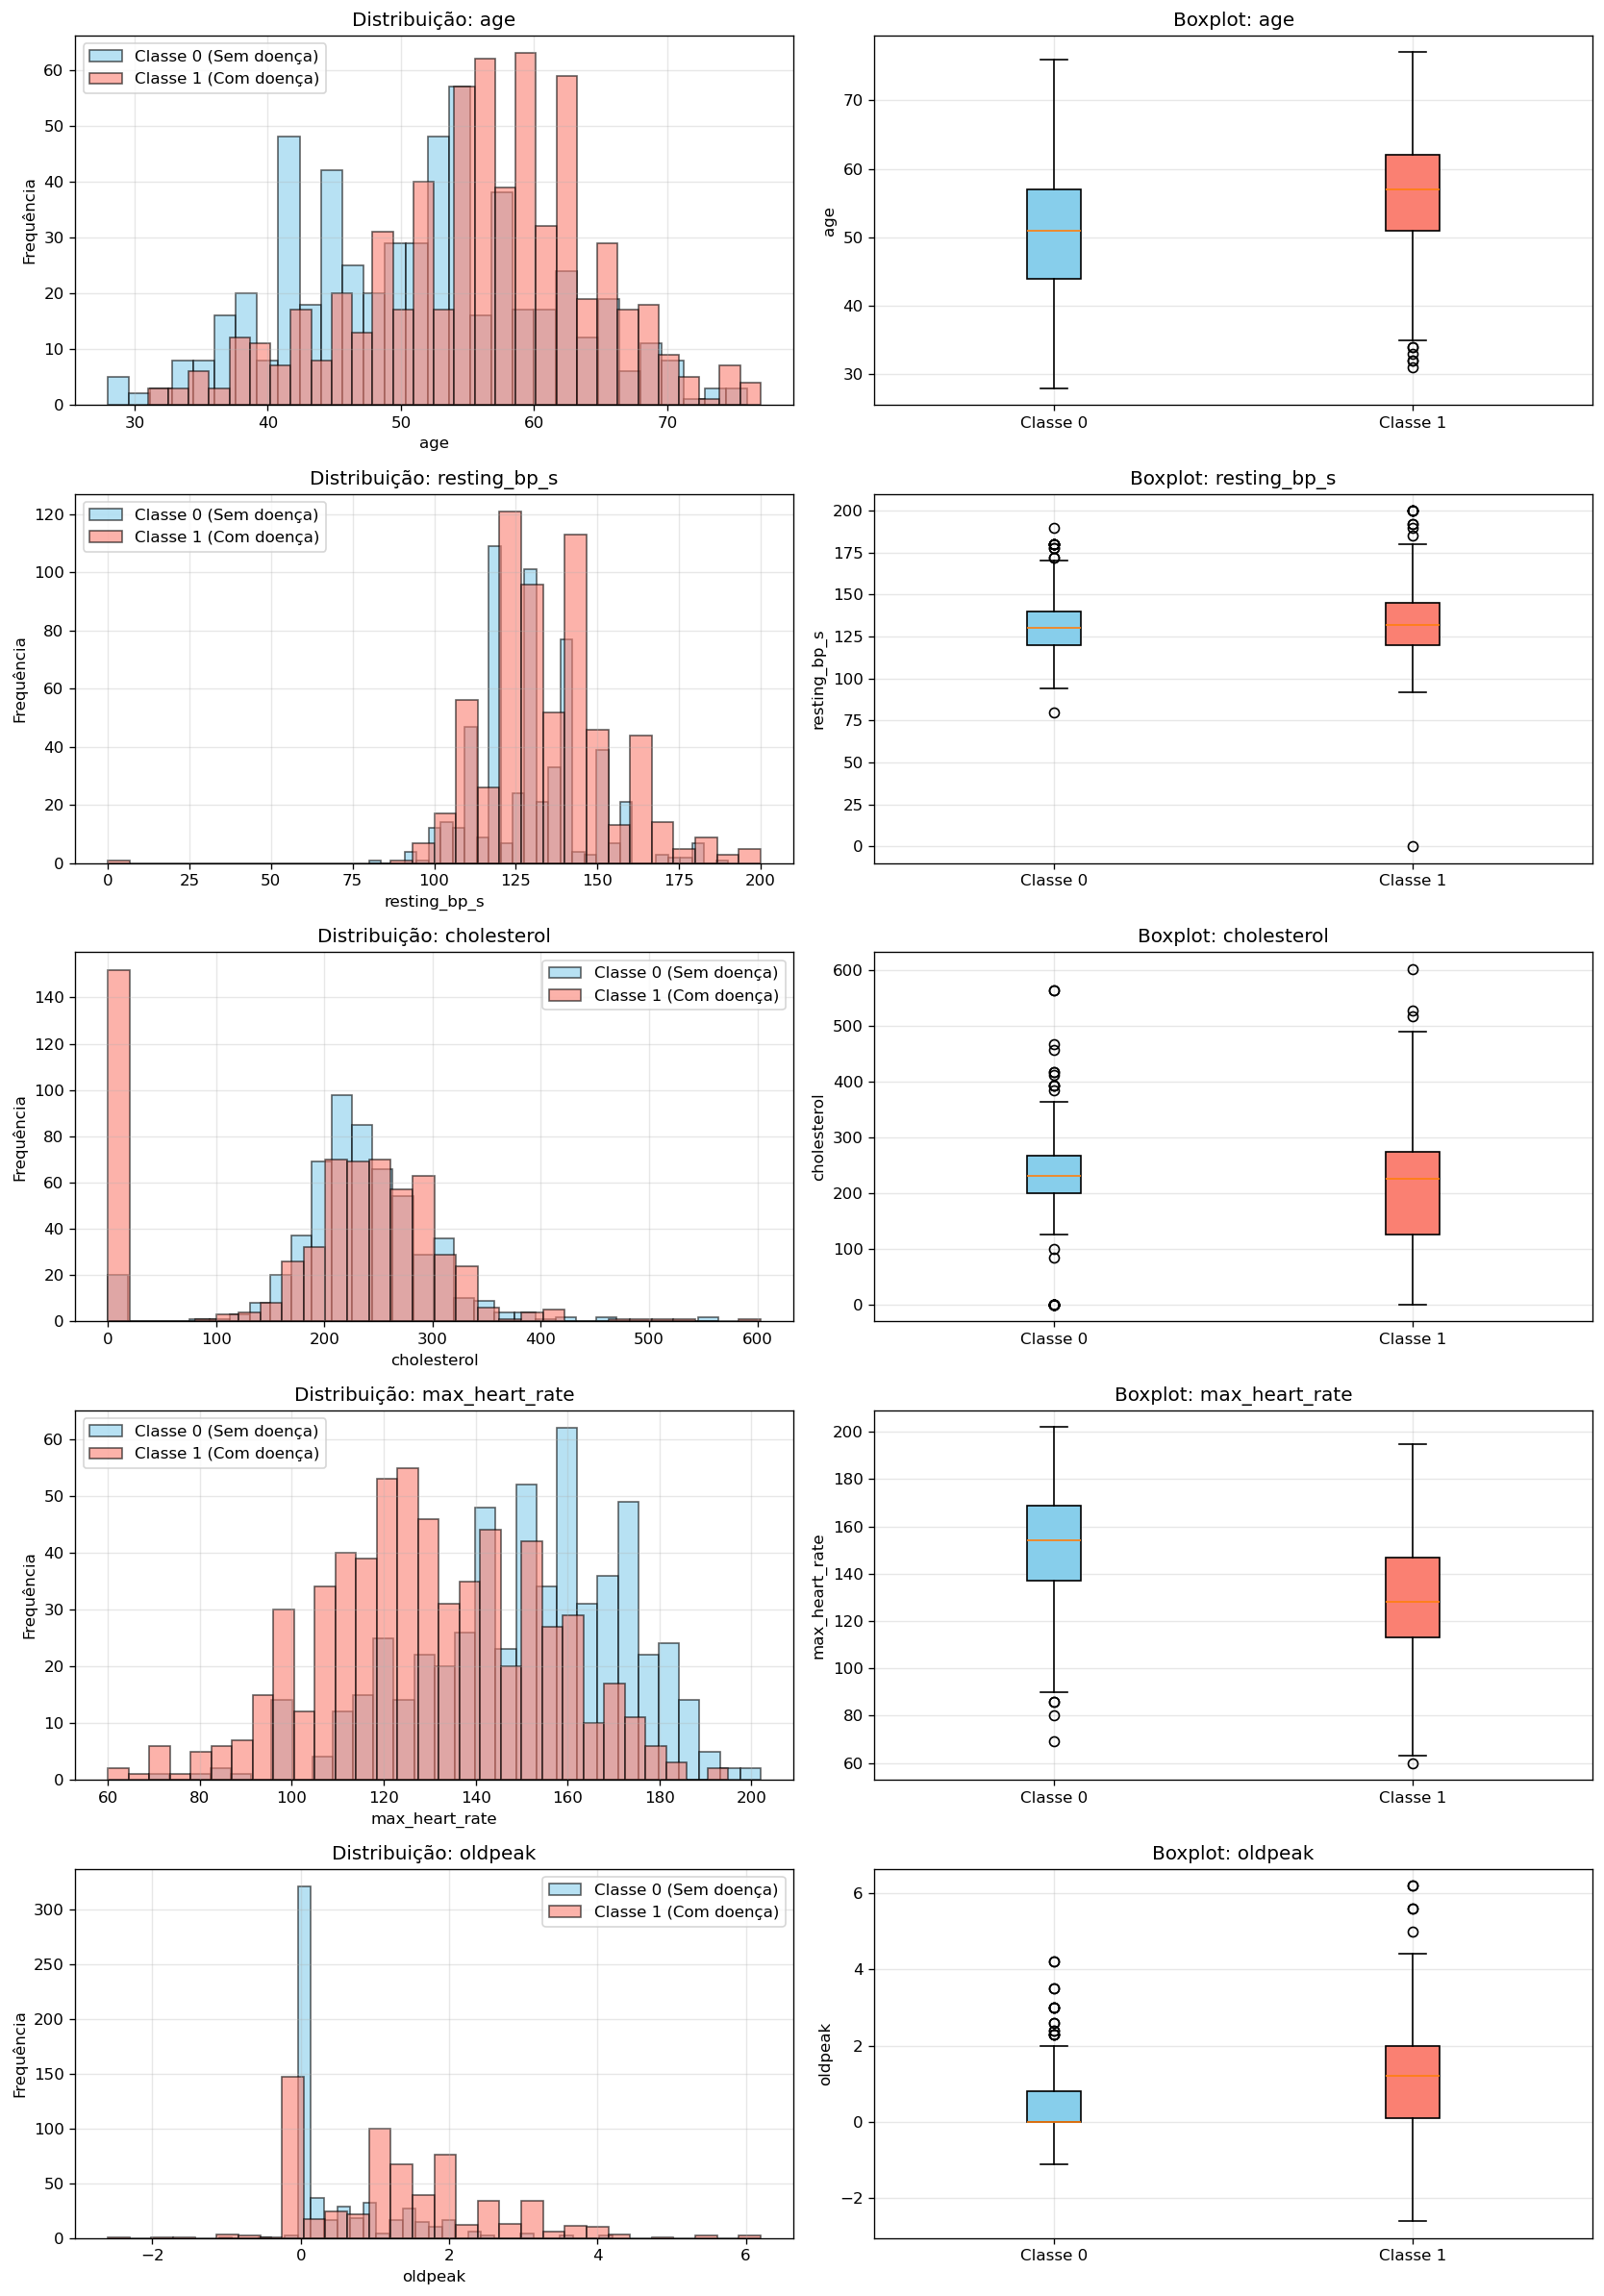

In [24]:
print("\n" + "="*80)
print("GERANDO VISUALIZAÇÕES...")
print("="*80)

fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 4*len(numeric_cols)))

for idx, col in enumerate(numeric_cols):
    # Histogramas sobrepostos
    ax1 = axes[idx, 0]
    class_0 = df[df[target_col] == 0][col]
    class_1 = df[df[target_col] == 1][col]
    
    ax1.hist(class_0, bins=30, alpha=0.6, label='Classe 0 (Sem doença)', color='skyblue', edgecolor='black')
    ax1.hist(class_1, bins=30, alpha=0.6, label='Classe 1 (Com doença)', color='salmon', edgecolor='black')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequência')
    ax1.set_title(f'Distribuição: {col}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Boxplots lado a lado
    ax2 = axes[idx, 1]
    data_to_plot = [class_0, class_1]
    bp = ax2.boxplot(data_to_plot, labels=['Classe 0', 'Classe 1'], patch_artist=True)
    bp['boxes'][0].set_facecolor('skyblue')
    bp['boxes'][1].set_facecolor('salmon')
    ax2.set_ylabel(col)
    ax2.set_title(f'Boxplot: {col}')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distribuicoes_numericas.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: distribuicoes_numericas.png")
plt.show()



✓ Gráfico salvo: matriz_correlacao.png


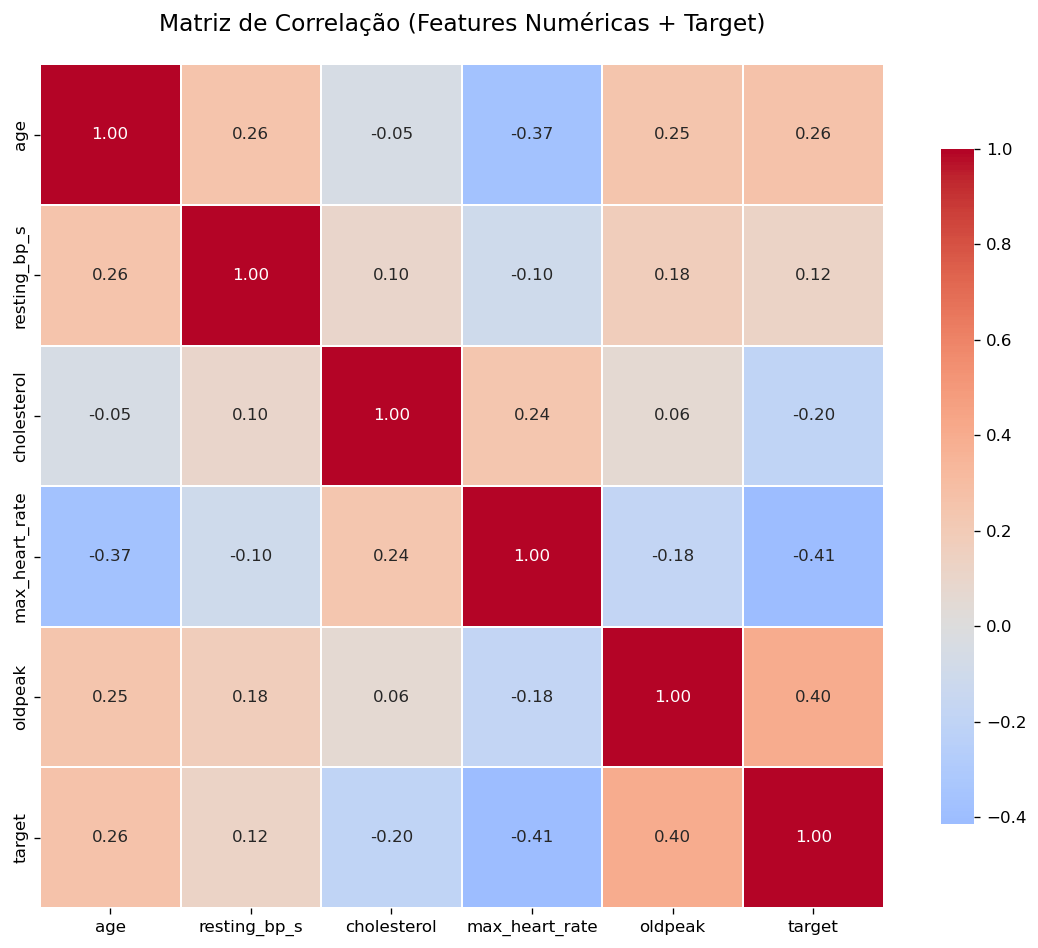

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação (Features Numéricas + Target)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('matriz_correlacao.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: matriz_correlacao.png")
plt.show()

✓ Gráfico salvo: distribuicoes_categoricas.png


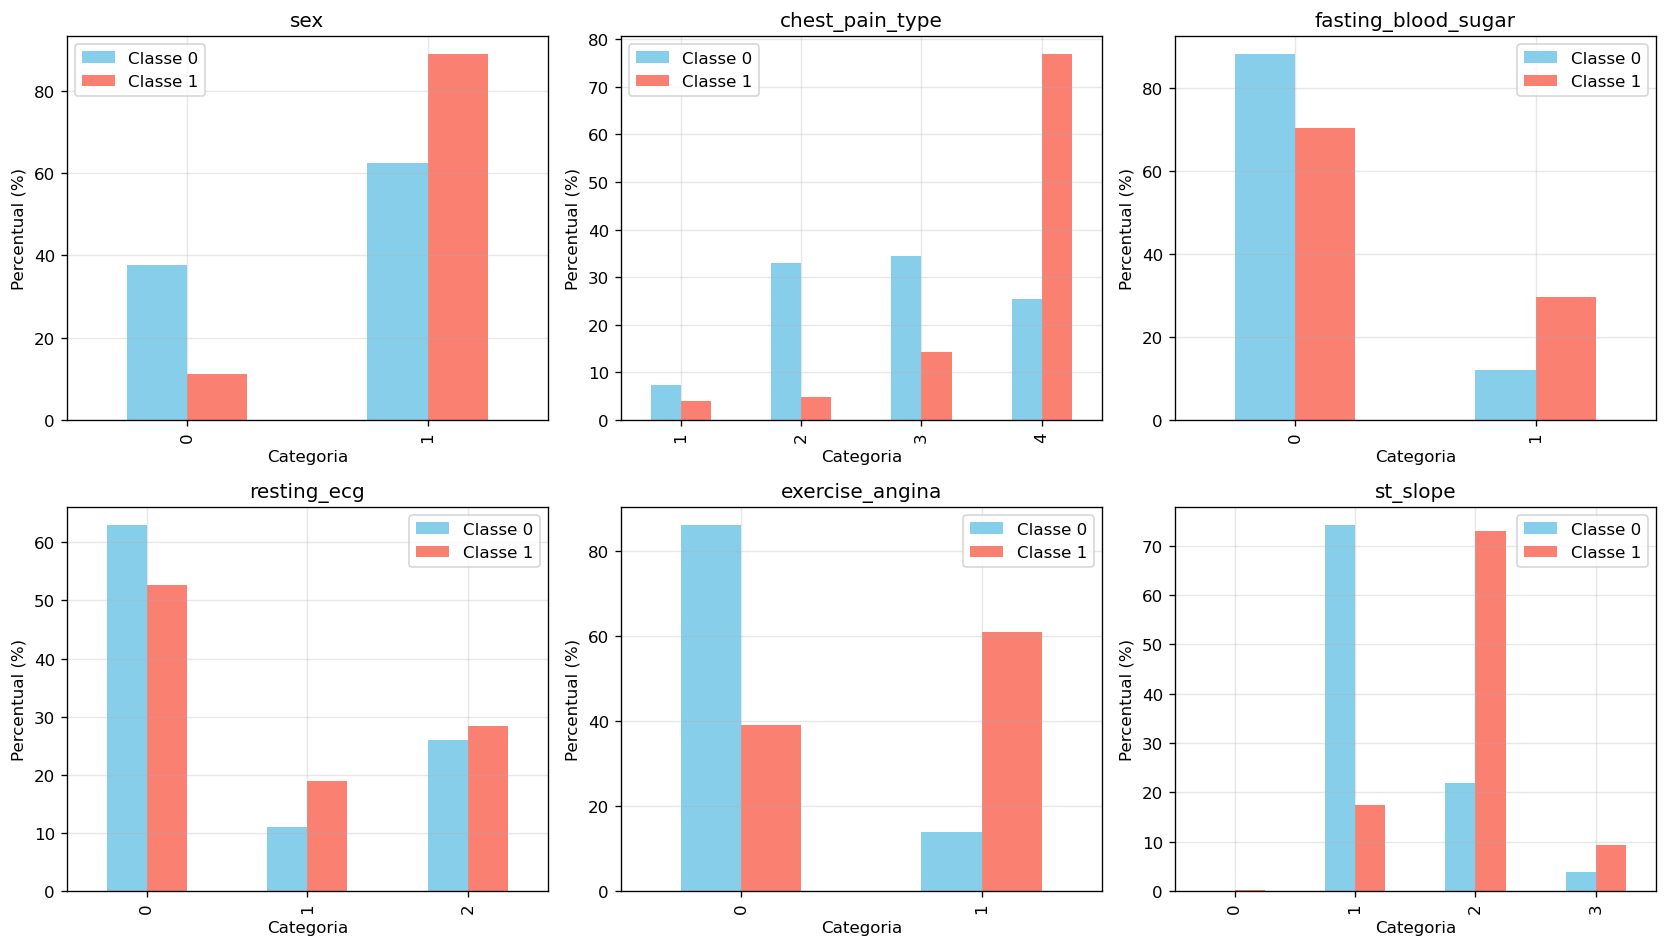

In [28]:
# ============================================================================
# CÉLULA 11: VISUALIZAÇÃO - DISTRIBUIÇÕES CATEGÓRICAS
# ============================================================================
n_cats = len(categorical_cols)
fig, axes = plt.subplots(2, (n_cats + 1) // 2, figsize=(14, 8))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    cross_tab = pd.crosstab(df[col], df[target_col], normalize='columns') * 100
    cross_tab.plot(kind='bar', ax=axes[idx], color=['skyblue', 'salmon'])
    axes[idx].set_title(f'{col}')
    axes[idx].set_xlabel('Categoria')
    axes[idx].set_ylabel('Percentual (%)')
    axes[idx].legend(['Classe 0', 'Classe 1'])
    axes[idx].grid(alpha=0.3)

# Esconder eixos extras se houver
for idx in range(n_cats, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('distribuicoes_categoricas.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo: distribuicoes_categoricas.png")
plt.show()



VISUALIZAÇÃO PCA (2D)
Variância explicada pelo PC1: 33.87%
Variância explicada pelo PC2: 24.00%
Variância total explicada: 57.87%

✓ Gráfico salvo: pca_separabilidade.png


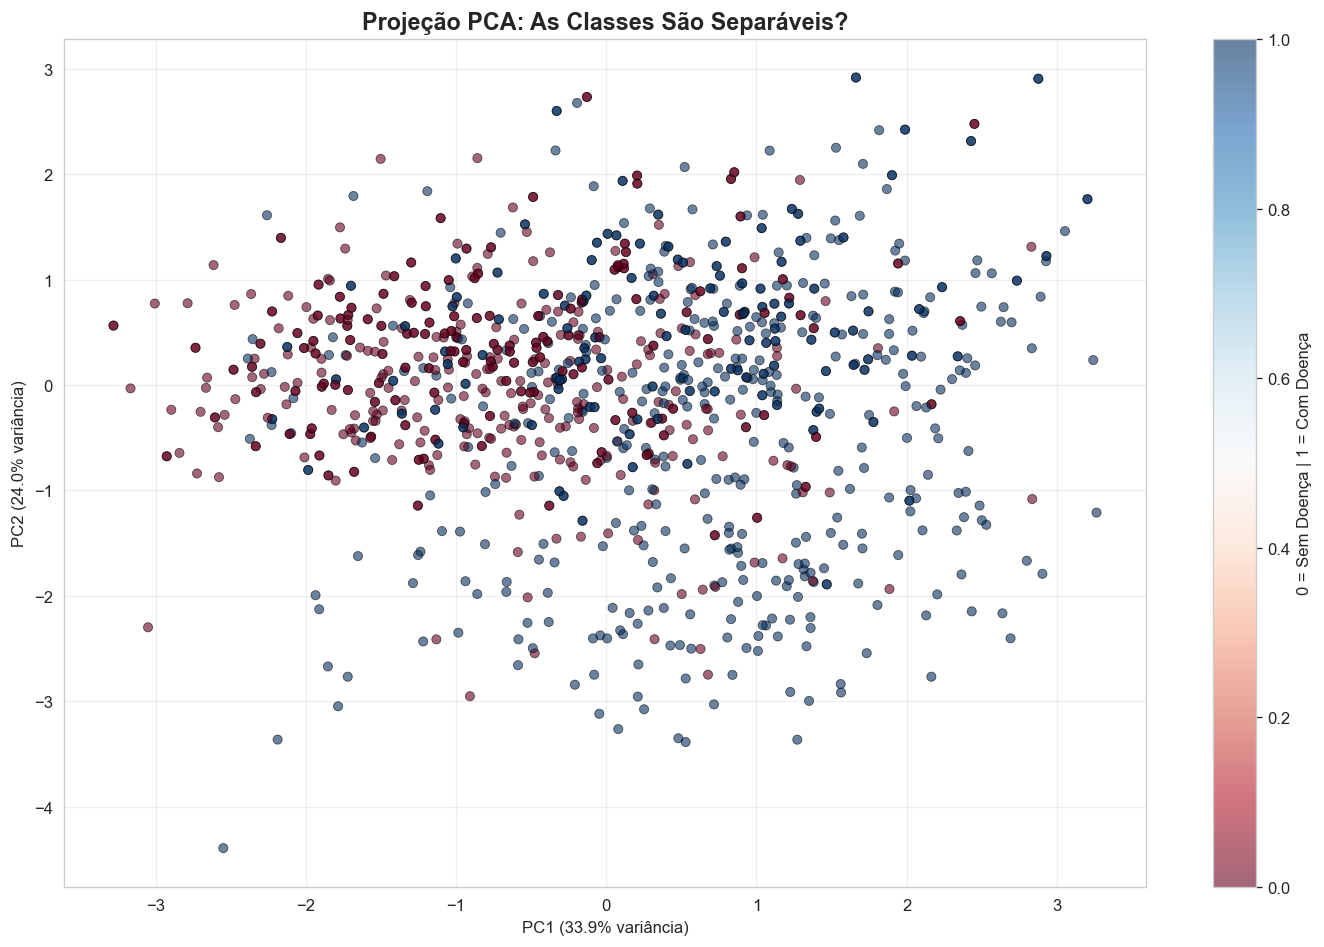


 INTERPRETAÇÃO DO PCA:
   - Pontos azuis (0) e vermelhos (1) MISTURADOS → classes não separáveis
   - Pontos bem SEPARADOS em grupos → classes distintas


In [53]:
print("\n" + "="*80)
print("VISUALIZAÇÃO PCA (2D)")
print("="*80)

# Preparar dados
X_numeric = df[numeric_cols].fillna(df[numeric_cols].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Variância total explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y, cmap='RdBu', alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='0 = Sem Doença | 1 = Com Doença')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)')
plt.title('Projeção PCA: As Classes São Separáveis?', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_separabilidade.png', dpi=150, bbox_inches='tight')
print("\n✓ Gráfico salvo: pca_separabilidade.png")
plt.show()

print("\n INTERPRETAÇÃO DO PCA:")
print("   - Pontos azuis (0) e vermelhos (1) MISTURADOS → classes não separáveis")
print("   - Pontos bem SEPARADOS em grupos → classes distintas")


In [55]:
print("\n" + "="*80)
print("RESUMO FINAL E RECOMENDAÇÕES")
print("="*80)

print("\nCARACTERÍSTICAS DO DATASET:")
print(f"  • Total de amostras: {len(df)}")
print(f"  • Features numéricas: {len(numeric_cols)}")
print(f"  • Features categóricas: {len(categorical_cols)}")
print(f"  • Balanceamento: {ratio:.2f}:1")

print("\nPOTENCIAL PREDITIVO:")
if large >= 2:
    print("  ✓ ALTO - Múltiplas features com forte poder discriminativo")
elif large + medium >= 3:
    print("  ~ MODERADO - Algumas features úteis disponíveis")
else:
    print(" BAIXO - Poucas features discriminativas")
print("\n")
print("="*80)
print("EDA concluído com sucesso!")
print("="*80)


RESUMO FINAL E RECOMENDAÇÕES

CARACTERÍSTICAS DO DATASET:
  • Total de amostras: 1190
  • Features numéricas: 5
  • Features categóricas: 6
  • Balanceamento: 1.12:1

POTENCIAL PREDITIVO:
  ✓ ALTO - Múltiplas features com forte poder discriminativo


EDA concluído com sucesso!


### FEATURE ENGINEERING

In [57]:
print(f"\n{'='*60}")
print("FEATURE ENGINEERING")
print(f"{'='*60}")

df_X = df.drop(columns=[target_col]).copy()

# Garantir que todas as colunas são numéricas
for col in df_X.columns:
    df_X[col] = pd.to_numeric(df_X[col], errors='coerce')

# Preencher NaNs antes de criar features
df_X = df_X.fillna(df_X.median())

# Limpar nomes
df_X.columns = df_X.columns.str.replace('[', '_', regex=False)
df_X.columns = df_X.columns.str.replace(']', '_', regex=False)
df_X.columns = df_X.columns.str.replace('<', 'lt', regex=False)
df_X.columns = df_X.columns.str.replace('>', 'gt', regex=False)

# Criar interações (agora todas as colunas são numéricas)
df_X['cardio_risk_bp_chol'] = df_X['resting_bp_s'] * df_X['cholesterol'] / 100
df_X['cardio_risk_age_bp'] = df_X['age'] * df_X['resting_bp_s'] / 100
df_X['metabolic_score'] = (df_X['fasting_blood_sugar'] * 0.4 + 
                            df_X['cholesterol'] * 0.3 + df_X['age'] * 0.3) / 100
df_X['heart_activity_score'] = df_X['max_heart_rate'] * df_X['oldpeak']
df_X['chest_pain_age'] = df_X['chest_pain_type'] * df_X['age']
df_X['chest_pain_hr'] = df_X['chest_pain_type'] * df_X['max_heart_rate']
df_X['age_squared'] = df_X['age'] ** 2
df_X['age_cholesterol'] = df_X['age'] * df_X['cholesterol'] / 100
df_X['bp_age_ratio'] = df_X['resting_bp_s'] / (df_X['age'] + 1)
df_X['hr_age_ratio'] = df_X['max_heart_rate'] / (df_X['age'] + 1)
df_X['chol_age_ratio'] = df_X['cholesterol'] / (df_X['age'] + 1)
df_X['st_slope_oldpeak'] = df_X['st_slope'] * df_X['oldpeak']
df_X['oldpeak_squared'] = df_X['oldpeak'] ** 2
df_X['sex_chest_pain'] = df_X['sex'] * df_X['chest_pain_type']
df_X['sex_exercise_angina'] = df_X['sex'] * df_X['exercise_angina']
df_X['ecg_composite_score'] = df_X['resting_ecg'] * df_X['st_slope']
df_X['high_bp_flag'] = (df_X['resting_bp_s'] > 140).astype(int)
df_X['high_cholesterol_flag'] = (df_X['cholesterol'] > 240).astype(int)
df_X['low_hr_flag'] = (df_X['max_heart_rate'] < 100).astype(int)
df_X['elderly_flag'] = (df_X['age'] > 65).astype(int)

print(f"✓ Features originais + engineered: {df_X.shape[1]}")

# One-hot encoding para categóricas com múltiplos valores
categorical_to_encode = ['chest_pain_type', 'resting_ecg', 'st_slope']
categorical_to_encode = [col for col in categorical_to_encode if col in df_X.columns]

if categorical_to_encode:
    df_X = pd.get_dummies(df_X, columns=categorical_to_encode, drop_first=False, 
                          prefix=categorical_to_encode)

# Converter booleanos para int
bool_cols = df_X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df_X[bool_cols] = df_X[bool_cols].astype(int)

# Preencher qualquer NaN restante
df_X = df_X.fillna(df_X.median())

print(f"✓ Features após encoding: {df_X.shape[1]}")



FEATURE ENGINEERING
✓ Features originais + engineered: 31
✓ Features após encoding: 39


### SPLIT DOS DADOS

In [59]:
print(f"\n{'='*60}")
print("DIVISÃO DOS DADOS")
print(f"{'='*60}")

X_temp, X_test, y_temp, y_test = train_test_split(
    df_X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"✓ Train: {X_train.shape} | Dist: {Counter(y_train)}")
print(f"✓ Val:   {X_val.shape} | Dist: {Counter(y_val)}")
print(f"✓ Test:  {X_test.shape} | Dist: {Counter(y_test)}")


DIVISÃO DOS DADOS
✓ Train: (833, 39) | Dist: Counter({1: 440, 0: 393})
✓ Val:   (178, 39) | Dist: Counter({1: 94, 0: 84})
✓ Test:  (179, 39) | Dist: Counter({1: 95, 0: 84})


### Feature Selection

In [61]:
print(f"\n{'='*60}")
print("Feature Selection")
print(f"{'='*60}")

models_for_fs = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, iterations=100, 
                                   auto_class_weights='Balanced', allow_writing_files=False),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, 
                            scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1]),
    'LightGBM': LGBMClassifier(random_state=42, n_estimators=100, 
                              class_weight='balanced', verbose=-1)
}

feature_importances = pd.DataFrame(index=X_train.columns)

for name, model in models_for_fs.items():
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    feature_importances[name] = importances

feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values('mean', ascending=False)

n_features = min(30, len(feature_importances))
selected_features = feature_importances.head(n_features).index.tolist()

print(f"\n✓ Top 15 features selecionadas:")
print(feature_importances.head(15)[['mean']])

X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

print(f"\n✓ Features reduzidas: {X_train.shape[1]} → {X_train_sel.shape[1]}")


Feature Selection

✓ Top 15 features selecionadas:
                           mean
bp_age_ratio          76.777625
chol_age_ratio        75.743030
cardio_risk_age_bp    75.582735
cardio_risk_bp_chol   74.097497
chest_pain_hr         71.262669
max_heart_rate        68.105003
chest_pain_age        63.549696
hr_age_ratio          58.134243
heart_activity_score  53.574618
resting_bp_s          48.806291
age_cholesterol       48.098156
metabolic_score       41.316796
oldpeak               40.956147
cholesterol           33.718452
age                   31.629525

✓ Features reduzidas: 39 → 30


### SCALING

In [63]:
print(f"\n{'='*60}")
print("SCALING")
print(f"{'='*60}")

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_sel),
    columns=X_train_sel.columns,
    index=X_train_sel.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_sel),
    columns=X_val_sel.columns,
    index=X_val_sel.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_sel),
    columns=X_test_sel.columns,
    index=X_test_sel.index
)

print(f"✓ Train scaled: {X_train_scaled.shape}")
print(f"✓ Val scaled: {X_val_scaled.shape}")
print(f"✓ Test scaled: {X_test_scaled.shape}")



SCALING
✓ Train scaled: (833, 30)
✓ Val scaled: (178, 30)
✓ Test scaled: (179, 30)


### TESTE DE ESTRATÉGIAS DE SAMPLING

In [65]:
print(f"\n{'='*60}")
print("TESTE DE ESTRATÉGIAS DE SAMPLING")
print(f"{'='*60}")

sampling_strategies = {
    'SMOTE_0.8': SMOTE(random_state=42, sampling_strategy=0.8, k_neighbors=5),
    'SMOTE_1.0': SMOTE(random_state=42, sampling_strategy=1.0, k_neighbors=5),
    'ADASYN': ADASYN(random_state=42, sampling_strategy=0.8),
    'SMOTETomek': SMOTETomek(random_state=42, sampling_strategy=0.8)
}

best_f1 = 0
best_sampler_name = None
best_X_train_res = None
best_y_train_res = None

for name, sampler in sampling_strategies.items():
    try:
        X_res, y_res = sampler.fit_resample(X_train_scaled, y_train)
        
        quick_model = CatBoostClassifier(
            verbose=0, random_state=42, iterations=200,
            auto_class_weights='Balanced', allow_writing_files=False
        )
        quick_model.fit(X_res, y_res)
        y_pred_val = quick_model.predict(X_val_scaled)
        
        f1 = f1_score(y_val, y_pred_val)
        ba = balanced_accuracy_score(y_val, y_pred_val)
        
        print(f"{name:20} | F1: {f1:.4f} | BA: {ba:.4f} | Dist: {Counter(y_res)}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_sampler_name = name
            best_X_train_res = X_res
            best_y_train_res = y_res
            
    except Exception as e:
        print(f"{name:20} | ERRO: {str(e)}")

print(f"\n✓ Melhor estratégia: {best_sampler_name} (F1 Val: {best_f1:.4f})")
print(f"✓ Distribuição após sampling: {Counter(best_y_train_res)}")



TESTE DE ESTRATÉGIAS DE SAMPLING
SMOTE_0.8            | ERRO: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.
SMOTE_1.0            | F1: 0.9022 | BA: 0.8998 | Dist: Counter({1: 440, 0: 440})
ADASYN               | ERRO: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.
SMOTETomek           | ERRO: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

✓ Melhor estratégia: SMOTE_1.0 (F1 Val: 0.9022)
✓ Distribuição após sampling: Counter({1: 440, 0: 440})


### TREINO DO ENSEMBLE

In [67]:
print(f"\n{'='*60}")
print("TREINAMENTO DO ENSEMBLE")
print(f"{'='*60}")

scale_pos_weight = Counter(best_y_train_res)[0] / Counter(best_y_train_res)[1]

catboost_model = CatBoostClassifier(
    verbose=0, random_state=42, allow_writing_files=False,
    iterations=700, learning_rate=0.03, depth=7,
    l2_leaf_reg=5, min_data_in_leaf=20,
    auto_class_weights='Balanced', eval_metric='F1'
)

xgboost_model = XGBClassifier(
    random_state=42, n_estimators=700, learning_rate=0.03,
    max_depth=7, min_child_weight=5,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss'
)

lgbm_model = LGBMClassifier(
    random_state=42, n_estimators=700, learning_rate=0.03,
    max_depth=7, min_child_samples=20, class_weight='balanced',
    subsample=0.8, colsample_bytree=0.8, verbose=-1
)

ensemble = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgboost', xgboost_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft', n_jobs=-1
)

print("Treinando ensemble (pode demorar alguns minutos)...")
ensemble.fit(best_X_train_res, best_y_train_res)


TREINAMENTO DO ENSEMBLE
Treinando ensemble (pode demorar alguns minutos)...


VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x000001BC08A785C0>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=5,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=700, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             colsample_bytree=0.8,
                                             learning_rate=0.03, max_depth=7,
                                             n_estimators=700, random_state=42,
                                             subsample=0.8, verbose=-1))],
                 n_jobs=-1, voting='soft')

#### Avaliação do Treino

In [68]:
print(f"\n{'='*60}")
print("RESULTADOS NO CONJUNTO DE VALIDAÇÃO")
print(f"{'='*60}")

y_pred_val = ensemble.predict(X_val_scaled)
y_proba_val = ensemble.predict_proba(X_val_scaled)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_val):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, target_names=['Sem Doença', 'Com Doença']))

print(f"\n{'='*60}")
print("RESULTADOS NO CONJUNTO DE TESTE")
print(f"{'='*60}")

y_pred_test = ensemble.predict(X_test_scaled)
y_proba_test = ensemble.predict_proba(X_test_scaled)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Sem Doença', 'Com Doença']))

cm_test = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(cm_test)


RESULTADOS NO CONJUNTO DE VALIDAÇÃO
Balanced Accuracy: 0.9158
F1-Score: 0.9198
ROC-AUC: 0.9659

Classification Report:
              precision    recall  f1-score   support

  Sem Doença       0.91      0.92      0.91        84
  Com Doença       0.92      0.91      0.92        94

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178


RESULTADOS NO CONJUNTO DE TESTE
Balanced Accuracy: 0.9334
F1-Score: 0.9362
ROC-AUC: 0.9737

Classification Report:
              precision    recall  f1-score   support

  Sem Doença       0.92      0.94      0.93        84
  Com Doença       0.95      0.93      0.94        95

    accuracy                           0.93       179
   macro avg       0.93      0.93      0.93       179
weighted avg       0.93      0.93      0.93       179


Confusion Matrix:
[[79  5]
 [ 7 88]]


### OTIMIZAÇÃO DE THRESHOLD

In [69]:
print(f"\n{'='*60}")
print("OTIMIZAÇÃO DE THRESHOLD")
print(f"{'='*60}")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"✓ Threshold ótimo: {optimal_threshold:.4f}")

y_pred_opt = (y_proba_test >= optimal_threshold).astype(int)

print(f"\nF1-Score (otimizado): {f1_score(y_test, y_pred_opt):.4f}")
print(f"Balanced Accuracy (otimizado): {balanced_accuracy_score(y_test, y_pred_opt):.4f}")

cm_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix (otimizado):")
print(cm_opt)


OTIMIZAÇÃO DE THRESHOLD
✓ Threshold ótimo: 0.4232

F1-Score (otimizado): 0.9368
Balanced Accuracy (otimizado): 0.9327

Confusion Matrix (otimizado):
[[78  6]
 [ 6 89]]


## Visualizações Finais


VISUALIZAÇÕES FINAIS

✓ Gráfico salvo: resultados_ensemble.png


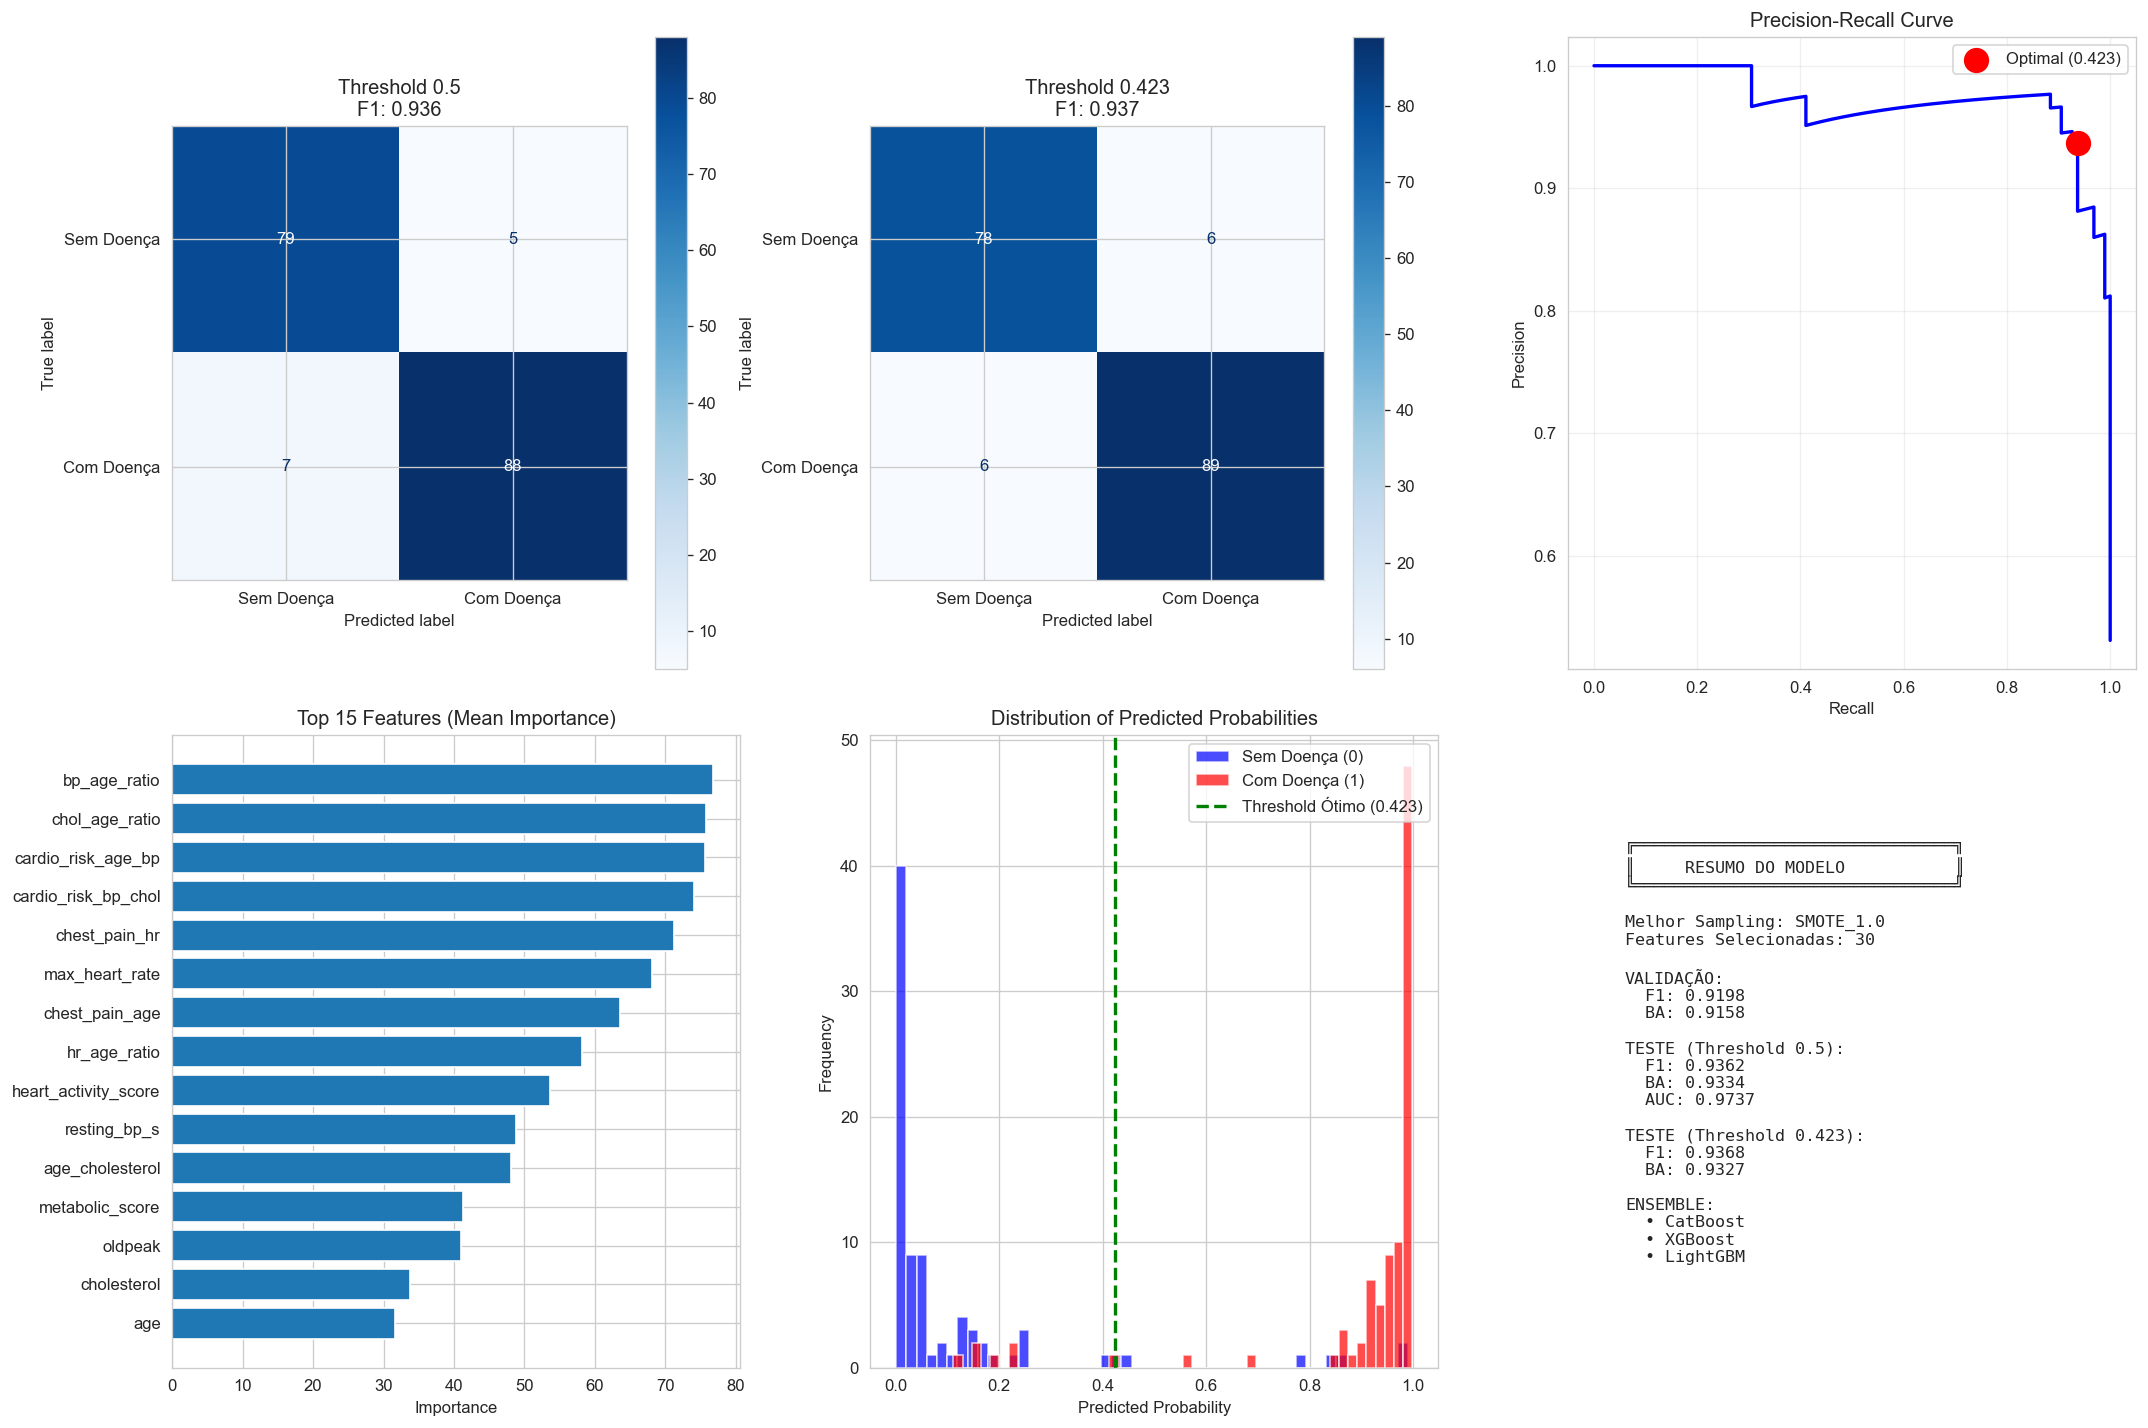

In [70]:
print(f"\n{'='*60}")
print("VISUALIZAÇÕES FINAIS")
print(f"{'='*60}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix - Padrão
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                display_labels=['Sem Doença', 'Com Doença'])
disp1.plot(cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Threshold 0.5\nF1: {f1_score(y_test, y_pred_test):.3f}')

# Confusion Matrix - Otimizado
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, 
                                display_labels=['Sem Doença', 'Com Doença'])
disp2.plot(cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Threshold {optimal_threshold:.3f}\nF1: {f1_score(y_test, y_pred_opt):.3f}')

# Precision-Recall Curve
axes[0, 2].plot(recall, precision, 'b-', linewidth=2)
axes[0, 2].scatter(recall[optimal_idx], precision[optimal_idx], 
                   color='red', s=200, zorder=5, label=f'Optimal ({optimal_threshold:.3f})')
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Feature Importance
feature_imp_display = feature_importances.head(15)[['mean']].sort_values('mean')
axes[1, 0].barh(feature_imp_display.index, feature_imp_display['mean'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Features (Mean Importance)')

# Distribuição de Probabilidades
axes[1, 1].hist(y_proba_test[y_test == 0], bins=50, alpha=0.7, 
                label='Sem Doença (0)', color='blue')
axes[1, 1].hist(y_proba_test[y_test == 1], bins=50, alpha=0.7, 
                label='Com Doença (1)', color='red')
axes[1, 1].axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, 
                   label=f'Threshold Ótimo ({optimal_threshold:.3f})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Predicted Probabilities')
axes[1, 1].legend()

# Resumo
axes[1, 2].axis('off')
summary_text = f"""
╔════════════════════════════════╗
║     RESUMO DO MODELO           ║
╚════════════════════════════════╝

Melhor Sampling: {best_sampler_name}
Features Selecionadas: {n_features}

VALIDAÇÃO:
  F1: {f1_score(y_val, y_pred_val):.4f}
  BA: {balanced_accuracy_score(y_val, y_pred_val):.4f}

TESTE (Threshold 0.5):
  F1: {f1_score(y_test, y_pred_test):.4f}
  BA: {balanced_accuracy_score(y_test, y_pred_test):.4f}
  AUC: {roc_auc_score(y_test, y_proba_test):.4f}

TESTE (Threshold {optimal_threshold:.3f}):
  F1: {f1_score(y_test, y_pred_opt):.4f}
  BA: {balanced_accuracy_score(y_test, y_pred_opt):.4f}

ENSEMBLE:
  • CatBoost
  • XGBoost  
  • LightGBM
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('resultados_ensemble.png', dpi=150, bbox_inches='tight')
print("\n✓ Gráfico salvo: resultados_ensemble.png")
plt.show()


## DIAGNÓSTICO FINAL

In [71]:
# ============================================
# 14. 
# ============================================
print(f"\n{'='*60}")
print("DIAGNÓSTICO FINAL")
print(f"{'='*60}")

final_f1 = f1_score(y_test, y_pred_test)
final_ba = balanced_accuracy_score(y_test, y_pred_test)
final_auc = roc_auc_score(y_test, y_proba_test)

print(f"\nMÉTRICAS FINAIS: \n")
print(f"F1-Score: {final_f1:.4f}")
print(f"Balanced Accuracy: {final_ba:.4f}")
print(f"ROC-AUC: {final_auc:.4f}")

if final_f1 < 0.3:
    print("\nRESULTADOS INSATISFATÓRIOS\n")
    print("1. Coletar mais dados")
    print("2. Adicionar features com maior poder discriminativo")
elif final_f1 < 0.6:
    print("\nRESULTADOS MODERADOS")
elif final_f1 > 0.6:
    print("\nRESULTADOS SATISFATÓRIOS\n")


DIAGNÓSTICO FINAL

MÉTRICAS FINAIS: 

F1-Score: 0.9362
Balanced Accuracy: 0.9334
ROC-AUC: 0.9737

RESULTADOS SATISFATÓRIOS



### One-Hot Enconding & Ordinal Enconding

Devido ao teor da pesquisa é importante usar Ordinal Enconding para variáveis que possuem uma escala real, como 
`alcohol_consumption`, `stress_level`, `sugar_consumption`, `exercise_habits` pela ordem: ['None', 'Low', 'Medium', 'High']

Para as restante variáveis não numéricas usamos One-Hot Enconding para obter uma valor binário

In [129]:
order = [['None', 'Low', 'Medium', 'High']] * len(column_execption)
encoder = OrdinalEncoder(categories=order)
df_X[column_execption] = encoder.fit_transform(df_X[column_execption])

df_X = pd.get_dummies(df_X, drop_first=False)
bool_cols = df_X.select_dtypes(include=['bool']).columns
df_X[bool_cols] = df_X[bool_cols].astype(int)

if 'age_group' in df_X.columns:
    df_X = df_X.drop(columns=['age_group'])

df_X = df_X.fillna(df_X.median())

print(f"Features após encoding: {df_X.shape[1]}")

Features após encoding: 58


In [131]:

print(f"\n{'='*60}")
print("FEATURE ENGINEERING")
print(f"{'='*60}")

df_X = df.drop(columns=[target_col])

# LIMPAR NOMES DAS COLUNAS (remover caracteres especiais)
df_X.columns = df_X.columns.str.replace('[', '_', regex=False)
df_X.columns = df_X.columns.str.replace(']', '_', regex=False)
df_X.columns = df_X.columns.str.replace('<', 'lt', regex=False)
df_X.columns = df_X.columns.str.replace('>', 'gt', regex=False)
df_X.columns = df_X.columns.str.replace(',', '_', regex=False)
df_X.columns = df_X.columns.str.replace(' ', '_', regex=False)

# CRIAR INTERAÇÕES IMPORTANTES
# Risco cardiovascular composto
df_X['cardio_risk_1'] = df_X['cholesterol_level'] * df_X['blood_pressure'] / 100
df_X['cardio_risk_2'] = df_X['bmi'] * df_X['age'] / 100
df_X['cardio_risk_3'] = df_X['triglyceride_level'] * df_X['cholesterol_level'] / 1000

# Perfil metabólico
df_X['metabolic_score'] = (
    df_X['fasting_blood_sugar'] * 0.3 + 
    df_X['triglyceride_level'] * 0.3 + 
    df_X['cholesterol_level'] * 0.2 +
    df_X['bmi'] * 0.2
) / 100

# Inflamação composta
df_X['inflammation_score'] = df_X['crp_level'] * df_X['homocysteine_level']

# Estilo de vida
df_X['lifestyle_score'] = df_X['sleep_hours'] / (df_X['stress_level'].replace({'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}) + 1)

# Idade ao quadrado (não-linearidade)
df_X['age_squared'] = df_X['age'] ** 2
df_X['bmi_squared'] = df_X['bmi'] ** 2

# Razões importantes
df_X['chol_hdl_ratio'] = df_X['cholesterol_level'] / (df_X['triglyceride_level'] + 1)
df_X['bp_age_ratio'] = df_X['blood_pressure'] / df_X['age']

print(f"Features originais + engineered: {df_X.shape[1]}")

# Encoding
from sklearn.preprocessing import OrdinalEncoder
order = [['None', 'Low', 'Medium', 'High']] * len(column_execption)
encoder = OrdinalEncoder(categories=order)
df_X[column_execption] = encoder.fit_transform(df_X[column_execption])

df_X = pd.get_dummies(df_X, drop_first=False)
bool_cols = df_X.select_dtypes(include=['bool']).columns
df_X[bool_cols] = df_X[bool_cols].astype(int)

if 'age_group' in df_X.columns:
    df_X = df_X.drop(columns=['age_group'])

df_X = df_X.fillna(df_X.median())

print(f"Features após encoding: {df_X.shape[1]}")


FEATURE ENGINEERING
Features originais + engineered: 31
Features após encoding: 58


In [133]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)
clf.fit(df_X, df_Y)

# Ver as regras
rules = export_text(clf, feature_names= df_X.columns.tolist())
print(rules)

# Ver importância das features
feature_importance = pd.DataFrame({
    'feature': df_X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(feature_importance.head(10))

NameError: name 'df_Y' is not defined

****

## Treinamento do Modelo

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X, y, test_size=0.25, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n{'='*60}")
print("SPLIT DOS DADOS")
print(f"{'='*60}")
print(f"Treino: {X_train.shape[0]} | Val: {X_val.shape[0]} | Teste: {X_test.shape[0]}")
print(f"Train: {Counter(y_train)}")
print(f"Val: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")


SPLIT DOS DADOS
Treino: 5764 | Val: 1442 | Teste: 2403
Train: Counter({0: 4610, 1: 1154})
Val: Counter({0: 1153, 1: 289})
Test: Counter({0: 1922, 1: 481})


In [137]:

# Treinar múltiplos modelos para feature importance
models_for_fs = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, iterations=100, auto_class_weights='Balanced', allow_writing_files=False),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1]),
    'LightGBM': LGBMClassifier(random_state=42, n_estimators=100, class_weight='balanced', verbose=-1)
}

feature_importances = pd.DataFrame(index=X_train.columns)

for name, model in models_for_fs.items():
    model.fit(X_train, y_train)
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.get_feature_importance()
    
    feature_importances[name] = importances

# Média das importâncias
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values('mean', ascending=False)

# Selecionar top features
n_features = min(30, len(feature_importances))  # Aumentado para 30
selected_features = feature_importances.head(n_features).index.tolist()

print(f"\nTop 15 features selecionadas:")
print(feature_importances.head(15)[['mean']])

X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

ValueError: feature_names must be string, and may not contain [, ] or <

In [139]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [141]:
print(f"\n{'='*60}")
print("TESTE DE ESTRATÉGIAS DE SAMPLING")
print(f"{'='*60}")

sampling_strategies = {
    'SMOTE_0.8': SMOTE(random_state=42, sampling_strategy=0.8, k_neighbors=5),
    'SMOTE_1.0': SMOTE(random_state=42, sampling_strategy=1.0, k_neighbors=5),
    'ADASYN': ADASYN(random_state=42, sampling_strategy=0.8),
    'SMOTETomek': SMOTETomek(random_state=42, sampling_strategy=0.8)
}

best_f1 = 0
best_sampler_name = None
best_X_train_res = None
best_y_train_res = None

for name, sampler in sampling_strategies.items():
    try:
        X_res, y_res = sampler.fit_resample(X_train_scaled, y_train)
        
        # Testar com modelo rápido
        quick_model = CatBoostClassifier(
            verbose=0, random_state=42, iterations=200,
            auto_class_weights='Balanced', allow_writing_files=False
        )
        quick_model.fit(X_res, y_res)
        y_pred_val = quick_model.predict(X_val_scaled)
        
        f1 = f1_score(y_val, y_pred_val)
        ba = balanced_accuracy_score(y_val, y_pred_val)
        
        print(f"{name:20} | F1: {f1:.4f} | BA: {ba:.4f} | Dist: {Counter(y_res)}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_sampler_name = name
            best_X_train_res = X_res
            best_y_train_res = y_res
    except Exception as e:
        print(f"{name:20} | ERRO: {str(e)}")

print(f"\n✓ Melhor estratégia: {best_sampler_name} (F1 Val: {best_f1:.4f})")



TESTE DE ESTRATÉGIAS DE SAMPLING
SMOTE_0.8            | ERRO: name 'X_val_scaled' is not defined
SMOTE_1.0            | ERRO: name 'X_val_scaled' is not defined
ADASYN               | ERRO: name 'X_val_scaled' is not defined
SMOTETomek           | ERRO: name 'X_val_scaled' is not defined

✓ Melhor estratégia: None (F1 Val: 0.0000)


In [142]:
print(f"\n{'='*60}")
print("TREINAMENTO DO ENSEMBLE")
print(f"{'='*60}")

scale_pos_weight = Counter(best_y_train_res)[0] / Counter(best_y_train_res)[1]

# Modelos otimizados
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    allow_writing_files=False,
    iterations=700,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    min_data_in_leaf=20,
    auto_class_weights='Balanced',
    eval_metric='F1'
)

xgboost_model = XGBClassifier(
    random_state=42,
    n_estimators=700,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=5,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=700,
    learning_rate=0.03,
    max_depth=7,
    min_child_samples=20,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8,
    verbose=-1
)

# Voting Ensemble com soft voting
ensemble = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgboost', xgboost_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft',
    n_jobs=-1
)

print("Treinando ensemble (pode demorar alguns minutos)...")
ensemble.fit(best_X_train_res, best_y_train_res)

# ============================================
# 8. AVALIAÇÃO NA VALIDAÇÃO
# ============================================
print(f"\n{'='*60}")
print("RESULTADOS NO CONJUNTO DE VALIDAÇÃO")
print(f"{'='*60}")

y_pred_val = ensemble.predict(X_val_scaled)
y_proba_val = ensemble.predict_proba(X_val_scaled)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_val):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))



TREINAMENTO DO ENSEMBLE


ZeroDivisionError: division by zero

In [ ]:
# ============================================
# 9. AVALIAÇÃO NO TESTE
# ============================================
print(f"\n{'='*60}")
print("RESULTADOS NO CONJUNTO DE TESTE")
print(f"{'='*60}")

y_pred_test = ensemble.predict(X_test_scaled)
y_proba_test = ensemble.predict_proba(X_test_scaled)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)

In [ ]:
print(f"\n{'='*60}")
print("OTIMIZAÇÃO DE THRESHOLD")
print(f"{'='*60}")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"Threshold ótimo: {optimal_threshold:.4f}")

y_pred_opt = (y_proba_test >= optimal_threshold).astype(int)
print(f"\nF1-Score (otimizado): {f1_score(y_test, y_pred_opt):.4f}")
print(f"Balanced Accuracy (otimizado): {balanced_accuracy_score(y_test, y_pred_opt):.4f}")
print("\nConfusion Matrix (otimizado):")
cm_opt = confusion_matrix(y_test, y_pred_opt)
print(cm_opt)

In [ ]:
# ============================================
# 11. ANÁLISE DETALHADA
# ============================================
print(f"\n{'='*60}")
print("ANÁLISE DE ERROS")
print(f"{'='*60}")

fp_idx = (y_test == 0) & (y_pred_test == 1)
fn_idx = (y_test == 1) & (y_pred_test == 0)
tp_idx = (y_test == 1) & (y_pred_test == 1)
tn_idx = (y_test == 0) & (y_pred_test == 0)

print(f"Verdadeiros Positivos: {tp_idx.sum()}")
print(f"Verdadeiros Negativos: {tn_idx.sum()}")
print(f"Falsos Positivos: {fp_idx.sum()}")
print(f"Falsos Negativos: {fn_idx.sum()}")

if fp_idx.sum() > 0:
    print(f"\nProb. média Falsos Positivos: {y_proba_test[fp_idx].mean():.4f} (±{y_proba_test[fp_idx].std():.4f})")
if fn_idx.sum() > 0:
    print(f"Prob. média Falsos Negativos: {y_proba_test[fn_idx].mean():.4f} (±{y_proba_test[fn_idx].std():.4f})")
if tp_idx.sum() > 0:
    print(f"Prob. média Verdadeiros Positivos: {y_proba_test[tp_idx].mean():.4f} (±{y_proba_test[tp_idx].std():.4f})")
if tn_idx.sum() > 0:
    print(f"Prob. média Verdadeiros Negativos: {y_proba_test[tn_idx].mean():.4f} (±{y_proba_test[tn_idx].std():.4f})")


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix - Padrão
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No', 'Yes'])
disp1.plot(cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Threshold 0.5\nF1: {f1_score(y_test, y_pred_test):.3f}')

# Confusion Matrix - Otimizado
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=['No', 'Yes'])
disp2.plot(cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Threshold {optimal_threshold:.3f}\nF1: {f1_score(y_test, y_pred_opt):.3f}')

# Precision-Recall Curve
axes[0, 2].plot(recall, precision, 'b-', linewidth=2)
axes[0, 2].scatter(recall[optimal_idx], precision[optimal_idx], 
                   color='red', s=200, zorder=5)
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve')
axes[0, 2].grid(True, alpha=0.3)

# Feature Importance (média dos modelos)
feature_imp_display = feature_importances.head(15)[['mean']].sort_values('mean')
axes[1, 0].barh(feature_imp_display.index, feature_imp_display['mean'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Features (Mean Importance)')

# Distribuição de Probabilidades
axes[1, 1].hist(y_proba_test[y_test == 0], bins=50, alpha=0.7, label='Class 0 (No)', color='blue')
axes[1, 1].hist(y_proba_test[y_test == 1], bins=50, alpha=0.7, label='Class 1 (Yes)', color='red')
axes[1, 1].axvline(optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Predicted Probabilities')
axes[1, 1].legend()

# Comparação de Estratégias
axes[1, 2].axis('off')
summary_text = f"""
RESUMO DO MODELO

Melhor Sampling: {best_sampler_name}
Features Selecionadas: {n_features}

VALIDAÇÃO:
F1: {f1_score(y_val, y_pred_val):.4f}
BA: {balanced_accuracy_score(y_val, y_pred_val):.4f}

TESTE (Threshold 0.5):
F1: {f1_score(y_test, y_pred_test):.4f}
BA: {balanced_accuracy_score(y_test, y_pred_test):.4f}
AUC: {roc_auc_score(y_test, y_proba_test):.4f}

TESTE (Threshold Otimizado):
F1: {f1_score(y_test, y_pred_opt):.4f}
BA: {balanced_accuracy_score(y_test, y_pred_opt):.4f}

ENSEMBLE:
- CatBoost
- XGBoost  
- LightGBM
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()


In [ ]:
print(f"\n{'='*60}")
print("DIAGNÓSTICO E PRÓXIMOS PASSOS")
print(f"{'='*60}")

final_f1 = f1_score(y_test, y_pred_test)
final_ba = balanced_accuracy_score(y_test, y_pred_test)

if final_f1 < 0.3:
    print("\n⚠️  RESULTADOS AINDA INSATISFATÓRIOS")
    print("\nPROVÁVEIS CAUSAS:")
    print("Features não têm poder preditivo suficiente")
    print("\nRECOMENDAÇÕES:")
    print("- Coletar mais dados da classe minoritária")
elif final_f1 < 0.5:
    print("\n⚡ RESULTADOS MODERADOS")
    print("\nRECOMENDAÇÕES:")
else:
    print("\n✓ RESULTADOS SATISFATÓRIOS")
    print(f"\nF1-Score: {final_f1:.4f}")
    print(f"Balanced Accuracy: {final_ba:.4f}")
